In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from grn_benchmark.src.helper import plot_heatmap
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# make sure each column can use more horizontal space
pd.set_option('display.max_colwidth', None)

In [8]:
adata = ad.read_h5ad('resources/grn_benchmark/evaluation_data/replogle_bulk.h5ad')
adata_de = ad.read_h5ad('resources/grn_benchmark/evaluation_data/replogle_de.h5ad')
adata

AnnData object with n_obs × n_vars = 3554 × 8248
    obs: 'sum_by', 'perturbation', 'is_tf', 'is_control', 'perturbation_type', 'cell_count'
    uns: 'data_reference', 'data_url', 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_summary', 'normalization_id'
    layers: 'lognorm'

In [10]:
for ky, value in adata.uns.items():
    adata_de.uns[ky] = value

In [4]:
!ls resources/grn_benchmark/evaluation_data

300BCG_bulk.h5ad    op_bulk.h5ad	       xaira_HCT116_de.h5ad
adamson_bulk.h5ad   parsebioscience_bulk.h5ad  xaira_HEK293T_bulk.h5ad
ibd_bulk.h5ad	    replogle_bulk.h5ad	       xaira_HEK293T_de.h5ad
nakatake_bulk.h5ad  replogle_de.h5ad
norman_bulk.h5ad    xaira_HCT116_bulk.h5ad


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Define cell types and their corresponding ground truth files
cell_types_info = {
    'PBMC': {'gt_files': ['PBMC_remap2022_pbmc.csv', 'PBMC_chipatlas_pbmc.csv', 'PBMC_unibind_pbmc.csv']},
    'K562': {'gt_files': ['K562_remap2022_k562.csv', 'K562_chipatlas_k562.csv', 'K562_unibind_k562.csv']},
    'HEK293': {'gt_files': ['HEK293_remap2022_hek293.csv', 'HEK293_chipatlas_hek293.csv', 'HEK293_unibind_hek293.csv']},
    'HCT116': {'gt_files': ['HCT116_remap2022_hct116.csv', 'HCT116_chipatlas_hct116.csv', 'HCT116_unibind_hct116.csv']}
}

ground_truth_types = ['remap2022', 'chipatlas', 'unibind']
gt_base_path = Path('resources/grn_benchmark/ground_truth/')

# Collect statistics for each cell type and ground truth type
stats_data = []

for cell_type, info in cell_types_info.items():
    print(f"Processing cell type: {cell_type}")
    
    for i, gt_type in enumerate(ground_truth_types):
        gt_file = info['gt_files'][i]
        gt_path = gt_base_path / gt_file
        
        if gt_path.exists():
            try:
                # Read ground truth file
                df = pd.read_csv(gt_path)
                
                # Count unique TFs
                n_tfs = df['source'].nunique()
                n_edges = len(df)
                n_targets = df['target'].nunique()
                
                stats_data.append({
                    'cell_type': cell_type,
                    'ground_truth': gt_type,
                    'n_tfs': n_tfs,
                    'n_edges': n_edges,
                    'n_targets': n_targets,
                    'avg_targets_per_tf': n_edges / n_tfs if n_tfs > 0 else 0
                })
                
                print(f"  {gt_type}: {n_tfs} TFs, {n_edges} edges, {n_targets} targets")
                
            except Exception as e:
                print(f"  Error reading {gt_file}: {e}")
                stats_data.append({
                    'cell_type': cell_type,
                    'ground_truth': gt_type,
                    'n_tfs': 0,
                    'n_edges': 0,
                    'n_targets': 0,
                    'avg_targets_per_tf': 0
                })
        else:
            print(f"  File not found: {gt_file}")
            stats_data.append({
                'cell_type': cell_type,
                'ground_truth': gt_type,
                'n_tfs': 0,
                'n_edges': 0,
                'n_targets': 0,
                'avg_targets_per_tf': 0
            })

# Convert to DataFrame
stats_df = pd.DataFrame(stats_data)
print(f"\nCollected stats for {len(stats_df)} cell type-GT combinations")
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
print(stats_df.pivot_table(index='cell_type', columns='ground_truth', values='n_tfs', fill_value=0))
stats_df

Processing cell type: PBMC
  remap2022: 12 TFs, 42917 edges, 13300 targets
  chipatlas: 59 TFs, 56695 edges, 13178 targets
  unibind: 46 TFs, 166947 edges, 16164 targets
Processing cell type: K562
  remap2022: 261 TFs, 1087856 edges, 17427 targets
  chipatlas: 336 TFs, 283874 edges, 14857 targets
  remap2022: 261 TFs, 1087856 edges, 17427 targets
  chipatlas: 336 TFs, 283874 edges, 14857 targets
  unibind: 86 TFs, 307451 edges, 16777 targets
Processing cell type: HEK293
  unibind: 86 TFs, 307451 edges, 16777 targets
Processing cell type: HEK293
  remap2022: 404 TFs, 1037668 edges, 17572 targets
  chipatlas: 276 TFs, 131309 edges, 14668 targets
  remap2022: 404 TFs, 1037668 edges, 17572 targets
  chipatlas: 276 TFs, 131309 edges, 14668 targets
  unibind: 41 TFs, 177850 edges, 16171 targets
Processing cell type: HCT116
  remap2022: 9 TFs, 41042 edges, 13200 targets
  chipatlas: 13 TFs, 9098 edges, 6462 targets
  unibind: 14 TFs, 37121 edges, 12487 targets

Collected stats for 12 cell typ

,cell_type,ground_truth,n_tfs,n_edges,n_targets,avg_targets_per_tf
0,PBMC,remap2022,12,42917,13300,3576.416667
1,PBMC,chipatlas,59,56695,13178,960.932203
2,PBMC,unibind,46,166947,16164,3629.282609
3,K562,remap2022,261,1087856,17427,4168.030651
4,K562,chipatlas,336,283874,14857,844.863095
5,K562,unibind,86,307451,16777,3575.011628
6,HEK293,remap2022,404,1037668,17572,2568.485149
7,HEK293,chipatlas,276,131309,14668,475.757246
8,HEK293,unibind,41,177850,16171,4337.804878
9,HCT116,remap2022,9,41042,13200,4560.222222


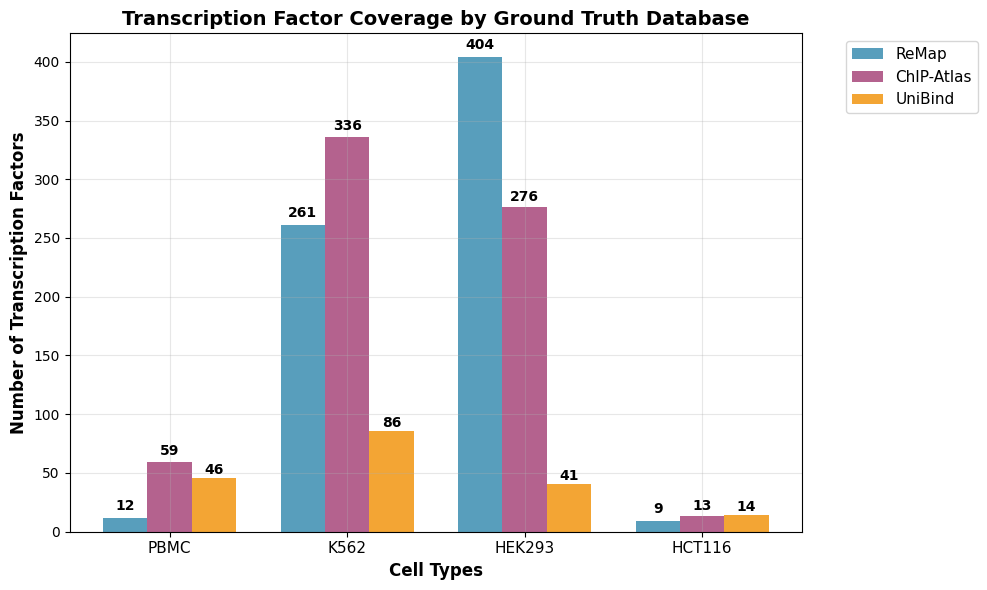

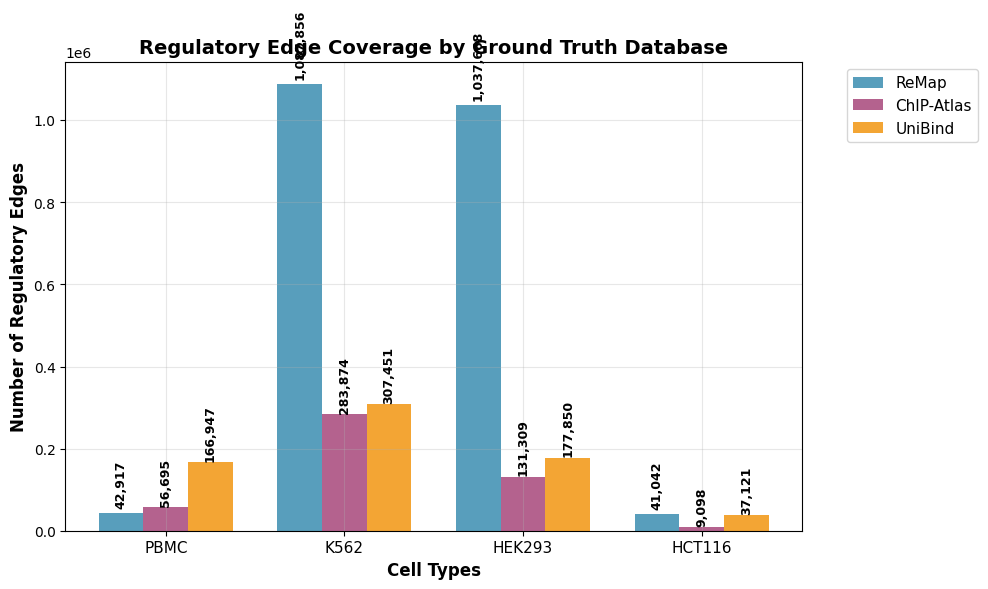

In [ ]:
# 1. Create clean bar plots for TF counts and Edge counts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pretty names mapping
gt_pretty_names = {
    'remap2022': 'ReMap',
    'chipatlas': 'ChIP-Atlas', 
    'unibind': 'UniBind'
}

# Colors for ground truth types
colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
gt_colors = dict(zip(['remap2022', 'chipatlas', 'unibind'], colors))

# Get cell types in order
cell_types = list(cell_types_info.keys())
x = np.arange(len(cell_types))
width = 0.25

# Create TF counts plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for i, gt_type in enumerate(['remap2022', 'chipatlas', 'unibind']):
    gt_data = stats_df[stats_df['ground_truth'] == gt_type]
    values = []
    for cell_type in cell_types:
        cell_data = gt_data[gt_data['cell_type'] == cell_type]
        if len(cell_data) > 0:
            values.append(cell_data['n_tfs'].iloc[0])
        else:
            values.append(0)
    
    bars = ax.bar(x + i * width, values, width, 
                  label=gt_pretty_names[gt_type], 
                  color=gt_colors[gt_type], alpha=0.8)
    
    # Add value labels on bars
    for j, (bar, val) in enumerate(zip(bars, values)):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(values)*0.01, 
                   f'{val}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Cell Types', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Transcription Factors', fontsize=12, fontweight='bold')
ax.set_title('Transcription Factor Coverage by Ground Truth Database', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(cell_types, fontsize=11)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

# Create Edge counts plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, gt_type in enumerate(['remap2022', 'chipatlas', 'unibind']):
    gt_data = stats_df[stats_df['ground_truth'] == gt_type]
    values = []
    for cell_type in cell_types:
        cell_data = gt_data[gt_data['cell_type'] == cell_type]
        if len(cell_data) > 0:
            values.append(cell_data['n_edges'].iloc[0])
        else:
            values.append(0)
    
    bars = ax.bar(x + i * width, values, width, 
                  label=gt_pretty_names[gt_type], 
                  color=gt_colors[gt_type], alpha=0.8)
    
    # Add value labels on bars (rotated for large numbers)
    for j, (bar, val) in enumerate(zip(bars, values)):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(values)*0.01, 
                   f'{val:,}', ha='center', va='bottom', fontsize=9, 
                   fontweight='bold', rotation=90)

ax.set_xlabel('Cell Types', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Regulatory Edges', fontsize=12, fontweight='bold')
ax.set_title('Regulatory Edge Coverage by Ground Truth Database', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(cell_types, fontsize=11)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()


OVERLAP ANALYSIS FOR PBMC


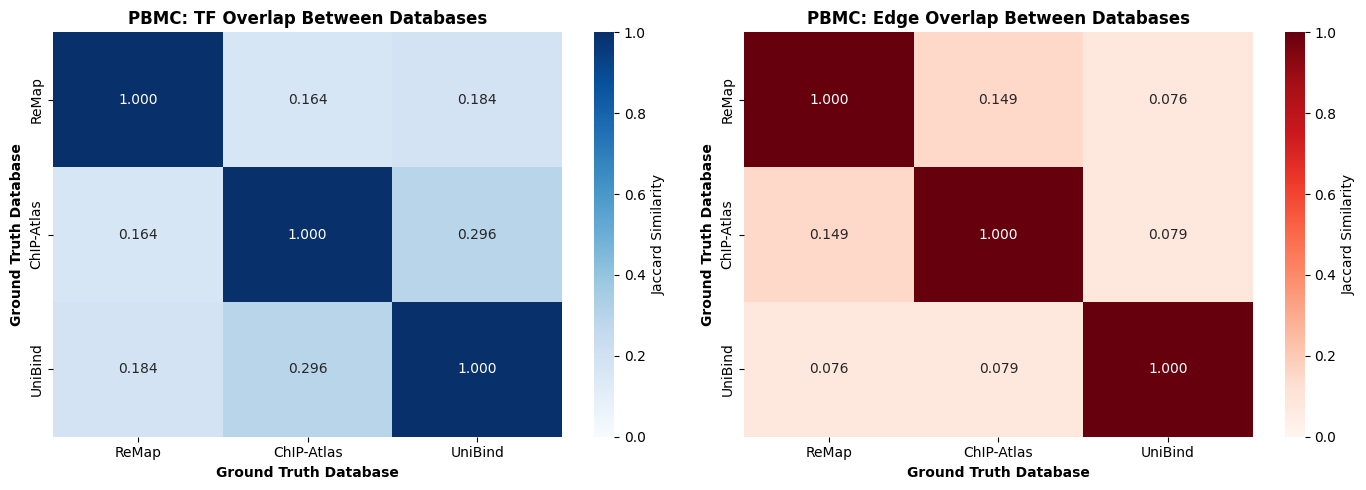


TF Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.164
  ReMap ∩ UniBind: 0.184
  ChIP-Atlas ∩ UniBind: 0.296

Edge Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.149
  ReMap ∩ UniBind: 0.076
  ChIP-Atlas ∩ UniBind: 0.079

Unique TF counts:
  ReMap: 12 TFs
  ChIP-Atlas: 59 TFs
  UniBind: 46 TFs

Unique edge counts:
  ReMap: 42917 edges
  ChIP-Atlas: 56695 edges
  UniBind: 166947 edges

OVERLAP ANALYSIS FOR K562


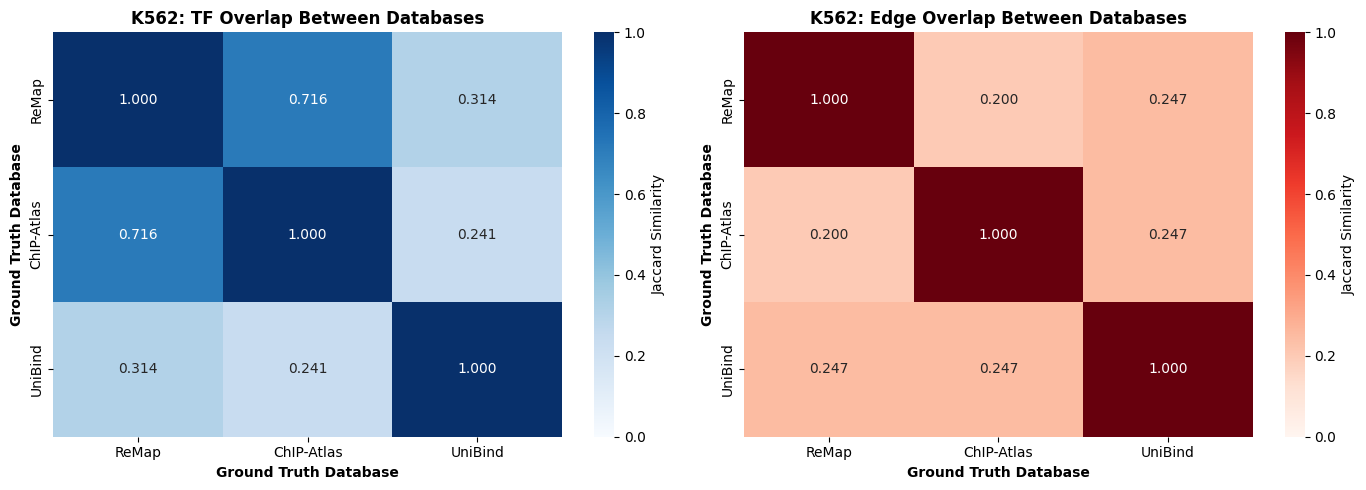


TF Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.716
  ReMap ∩ UniBind: 0.314
  ChIP-Atlas ∩ UniBind: 0.241

Edge Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.200
  ReMap ∩ UniBind: 0.247
  ChIP-Atlas ∩ UniBind: 0.247

Unique TF counts:
  ReMap: 261 TFs
  ChIP-Atlas: 336 TFs
  UniBind: 86 TFs

Unique edge counts:
  ReMap: 1087856 edges
  ChIP-Atlas: 283874 edges
  UniBind: 307451 edges

OVERLAP ANALYSIS FOR HEK293


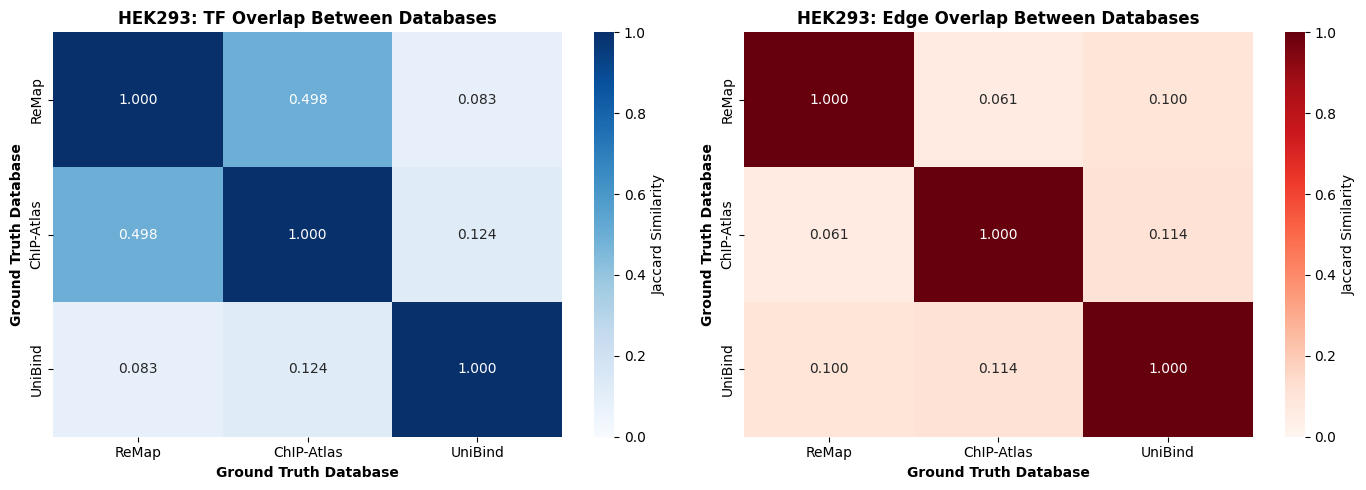


TF Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.498
  ReMap ∩ UniBind: 0.083
  ChIP-Atlas ∩ UniBind: 0.124

Edge Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.061
  ReMap ∩ UniBind: 0.100
  ChIP-Atlas ∩ UniBind: 0.114

Unique TF counts:
  ReMap: 404 TFs
  ChIP-Atlas: 276 TFs
  UniBind: 41 TFs

Unique edge counts:
  ReMap: 1037668 edges
  ChIP-Atlas: 131309 edges
  UniBind: 177850 edges

OVERLAP ANALYSIS FOR HCT116


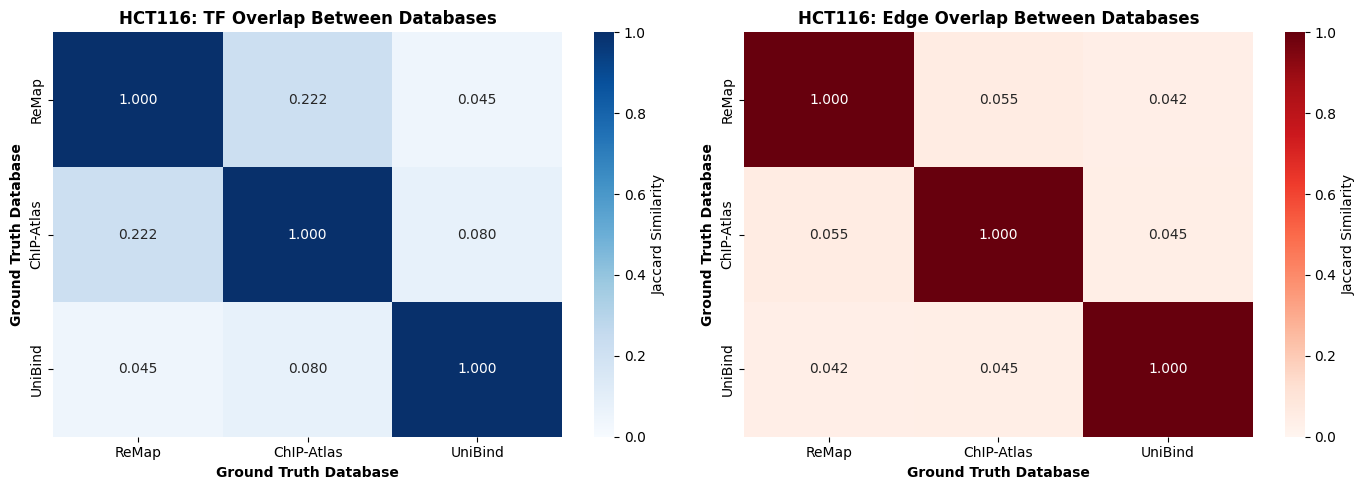


TF Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.222
  ReMap ∩ UniBind: 0.045
  ChIP-Atlas ∩ UniBind: 0.080

Edge Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.055
  ReMap ∩ UniBind: 0.042
  ChIP-Atlas ∩ UniBind: 0.045

Unique TF counts:
  ReMap: 9 TFs
  ChIP-Atlas: 13 TFs
  UniBind: 14 TFs

Unique edge counts:
  ReMap: 41042 edges
  ChIP-Atlas: 9098 edges
  UniBind: 37121 edges


In [19]:
# 2. Calculate and plot Jaccard similarity between ground truth datasets
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Calculate overlaps for each cell type
for cell_type in cell_types:
    print(f"\n{'='*60}")
    print(f"OVERLAP ANALYSIS FOR {cell_type}")
    print(f"{'='*60}")
    
    # Load the ground truth data for this cell type
    gt_data = {}
    gt_tfs = {}
    gt_edges = {}
    
    cell_info = cell_types_info[cell_type]
    
    for i, gt_type in enumerate(['remap2022', 'chipatlas', 'unibind']):
        gt_file = cell_info['gt_files'][i]
        gt_path = gt_base_path / gt_file
        
        if gt_path.exists():
            df = pd.read_csv(gt_path)
            gt_data[gt_type] = df
            gt_tfs[gt_type] = set(df['source'].unique())
            gt_edges[gt_type] = set(df.apply(lambda row: f"{row['source']}_{row['target']}", axis=1))
        else:
            gt_data[gt_type] = pd.DataFrame()
            gt_tfs[gt_type] = set()
            gt_edges[gt_type] = set()
    
    # Calculate Jaccard similarities for TFs and Edges
    gt_names = ['remap2022', 'chipatlas', 'unibind']
    pretty_names = [gt_pretty_names[gt] for gt in gt_names]
    
    # TF overlap matrix
    tf_jaccard = np.zeros((3, 3))
    for i, gt1 in enumerate(gt_names):
        for j, gt2 in enumerate(gt_names):
            tf_jaccard[i, j] = jaccard_similarity(gt_tfs[gt1], gt_tfs[gt2])
    
    # Edge overlap matrix  
    edge_jaccard = np.zeros((3, 3))
    for i, gt1 in enumerate(gt_names):
        for j, gt2 in enumerate(gt_names):
            edge_jaccard[i, j] = jaccard_similarity(gt_edges[gt1], gt_edges[gt2])
    
    # Create heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # TF overlap heatmap
    sns.heatmap(tf_jaccard, annot=True, fmt='.3f', 
                xticklabels=pretty_names, yticklabels=pretty_names,
                cmap='Blues', vmin=0, vmax=1, ax=ax1,
                cbar_kws={'label': 'Jaccard Similarity'})
    ax1.set_title(f'{cell_type}: TF Overlap Between Databases', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Ground Truth Database', fontweight='bold')
    ax1.set_ylabel('Ground Truth Database', fontweight='bold')
    
    # Edge overlap heatmap
    sns.heatmap(edge_jaccard, annot=True, fmt='.3f',
                xticklabels=pretty_names, yticklabels=pretty_names, 
                cmap='Reds', vmin=0, vmax=1, ax=ax2,
                cbar_kws={'label': 'Jaccard Similarity'})
    ax2.set_title(f'{cell_type}: Edge Overlap Between Databases', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Ground Truth Database', fontweight='bold')
    ax2.set_ylabel('Ground Truth Database', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTF Overlap Summary:")
    for i, gt1 in enumerate(gt_names):
        for j, gt2 in enumerate(gt_names):
            if i < j:  # Only print upper triangle (avoid duplicates)
                print(f"  {gt_pretty_names[gt1]} ∩ {gt_pretty_names[gt2]}: {tf_jaccard[i,j]:.3f}")
    
    print(f"\nEdge Overlap Summary:")
    for i, gt1 in enumerate(gt_names):
        for j, gt2 in enumerate(gt_names):
            if i < j:  # Only print upper triangle (avoid duplicates)
                print(f"  {gt_pretty_names[gt1]} ∩ {gt_pretty_names[gt2]}: {edge_jaccard[i,j]:.3f}")
    
    # Print unique counts
    print(f"\nUnique TF counts:")
    for gt in gt_names:
        print(f"  {gt_pretty_names[gt]}: {len(gt_tfs[gt])} TFs")
    
    print(f"\nUnique edge counts:")
    for gt in gt_names:
        print(f"  {gt_pretty_names[gt]}: {len(gt_edges[gt])} edges")

# Ground Truth Statistics Analysis
Analyze and plot the number of TFs per ground truth type across different datasets

In [2]:
# !cd /home/jnourisa/projs/ongoing/task_grn_inference & bash src/metrics/tf_binding/run_local.sh

/vol/tmp/users/jnourisa/ipykernel_2005414/3086680482.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_mean)
/vol/tmp/users/jnourisa/ipykernel_2005414/3086680482.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_mean)
/vol/tmp/users/jnourisa/ipykernel_2005414/3086680482.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is 

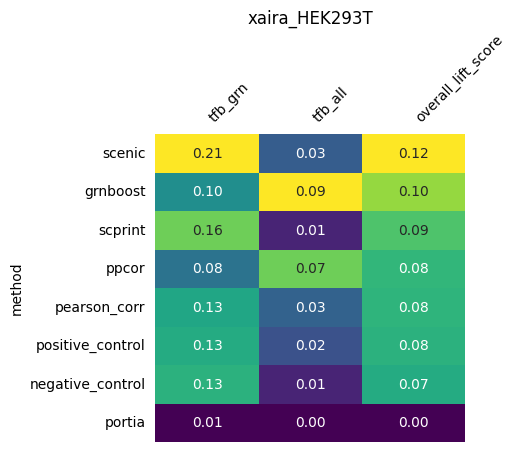

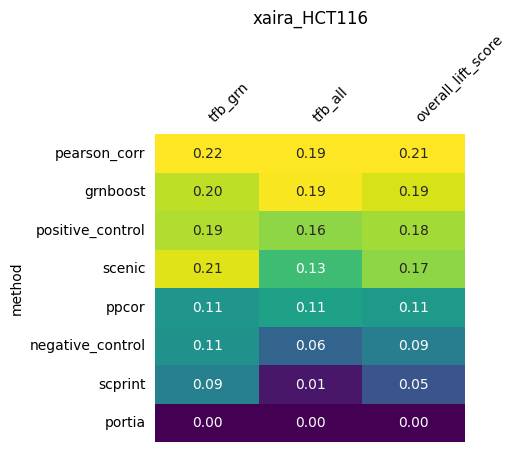

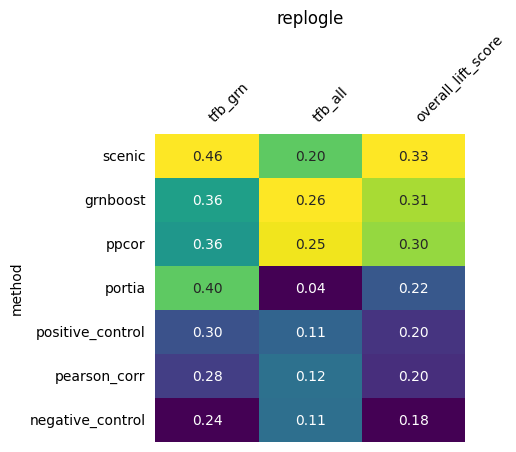

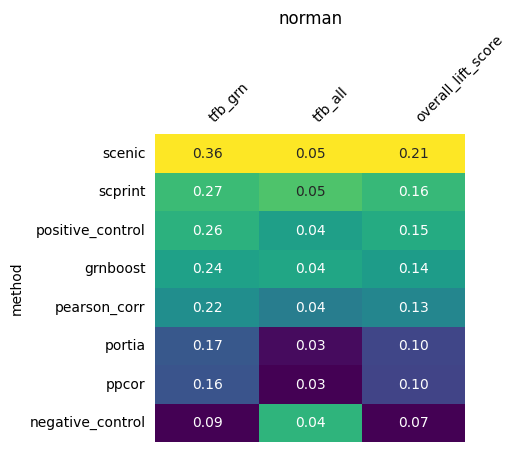

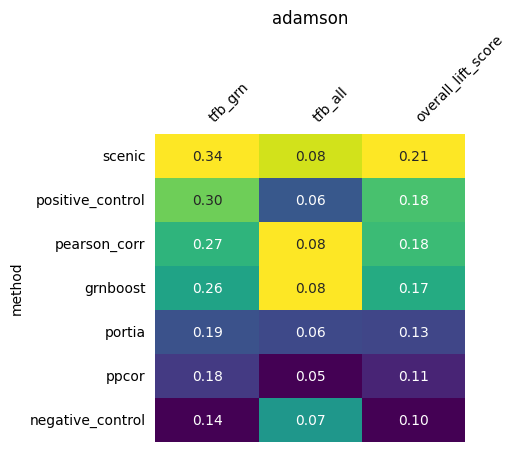

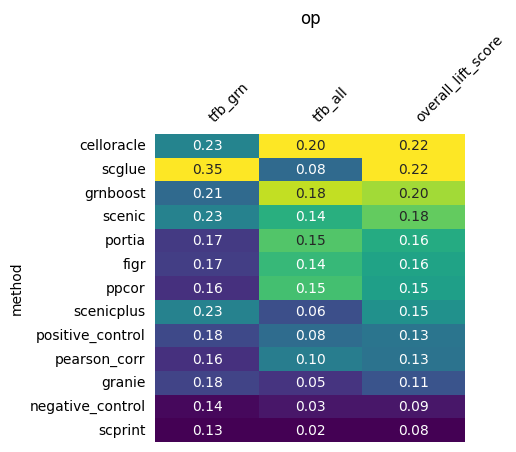

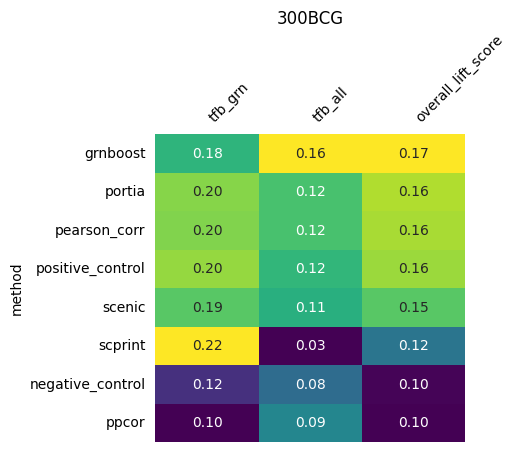

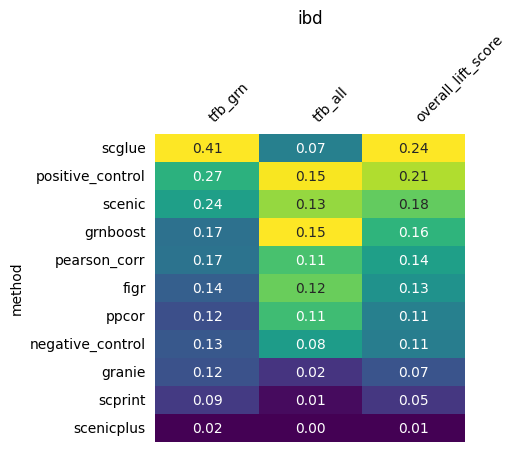

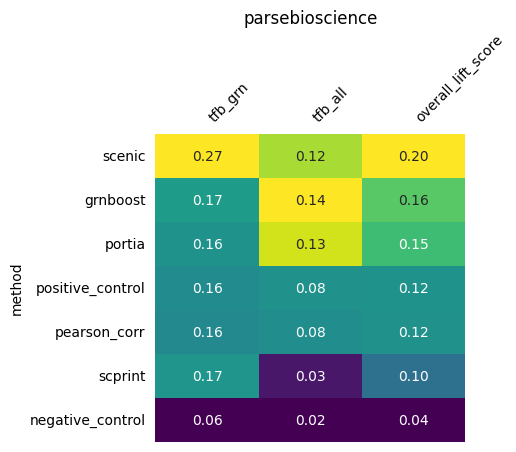

In [11]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

datasets = ['xaira_HEK293T', 'xaira_HCT116', 'replogle', 'norman',  'adamson', 'op',  "300BCG", "ibd", 'parsebioscience']
ground_truths = ['remap2022', 'chipatlas', 'unibind']

for dataset in datasets:
    all_results = []  
    for gt in ground_truths:
        try:
            df = pd.read_csv(f'output/tf_binding/summary_{dataset}_{gt}.csv')
        except FileNotFoundError:
            continue
        df = df.pivot(index='method', columns='metric', values='value')
        try:
            df = df[['tfb_grn', 'tfb_all',
                     'n_tfs_evaluated']]
        except KeyError as e:
            print(f"Missing columns in {dataset} - {gt}: {e}")
            continue
        metric_cols = [c for c in df.columns if c != 'n_tfs_evaluated']
        df_norm = df[metric_cols].copy()
        for c in metric_cols:
            min_val, max_val = df_norm[c].min(), df_norm[c].max()
            if max_val > min_val:
                df_norm[c] = (df_norm[c] - min_val) / (max_val - min_val)
            else:
                df_norm[c] = 0  
        for c in metric_cols:
            df[f'{c}_norm'] = df_norm[c]
        
        df['ground_truth'] = gt
        all_results.append(df.reset_index())
    if not all_results:
        print(f"No valid results found for {dataset}")
        continue
    combined = pd.concat(all_results, ignore_index=True)
    def weighted_mean(x):
        weights = x['n_tfs_evaluated']
        result = {}
        for c in x.columns:
            if c in ['tfb_grn', 
                     'tfb_all']:
                result[c] = (x[c] * weights).sum() / weights.sum()
        return pd.Series(result)
    summary = (
        combined
        .groupby('method')
        .apply(weighted_mean)
        .reset_index()
    )
    lift_cols = ['tfb_grn', 'tfb_all']
    summary['overall_lift_score'] = summary[lift_cols].mean(axis=1)
    summary = summary.sort_values('overall_lift_score', ascending=False)
    plot_heatmap(summary.set_index('method'), name=f'{dataset}_summary', cmap="viridis")
    plt.title(f'{dataset}')

/home/jnourisa/projs/ongoing/grn_benchmark/src/helper.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)


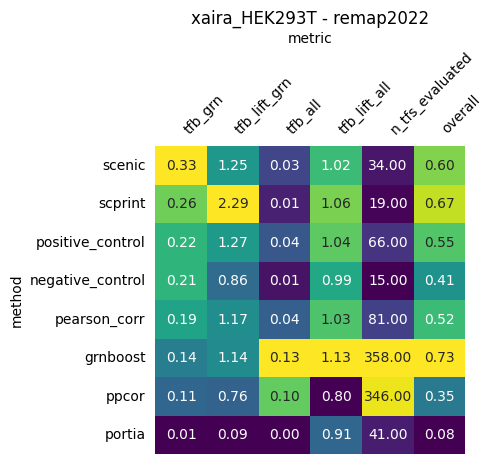

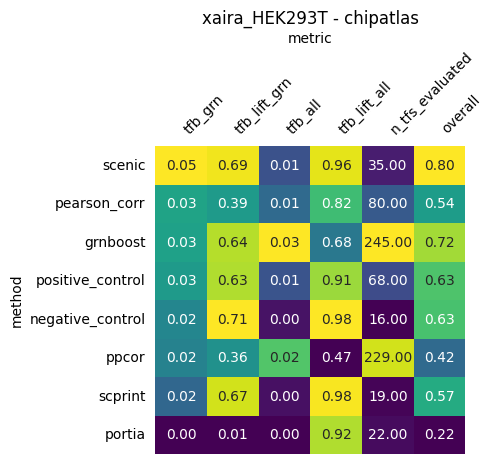

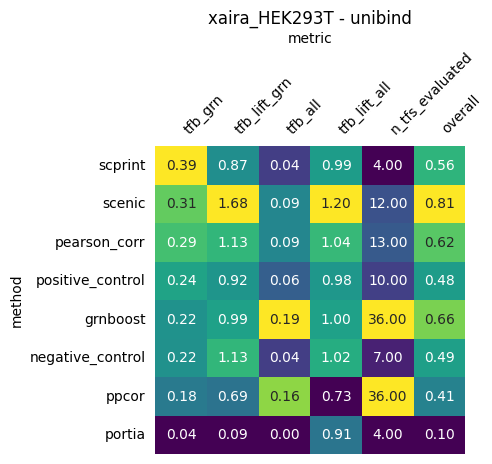

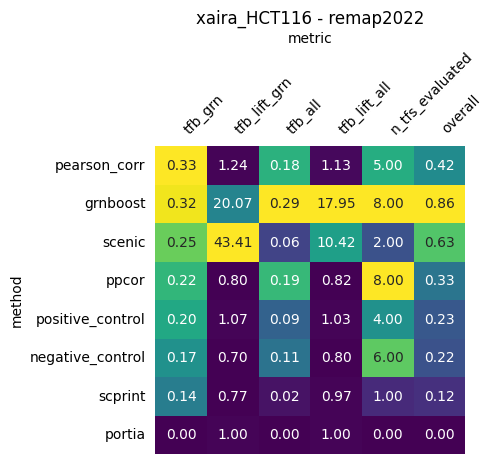

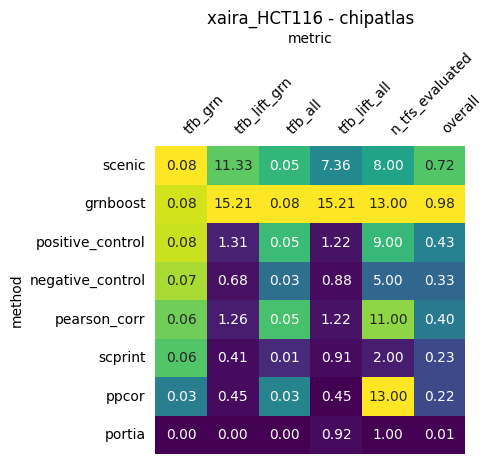

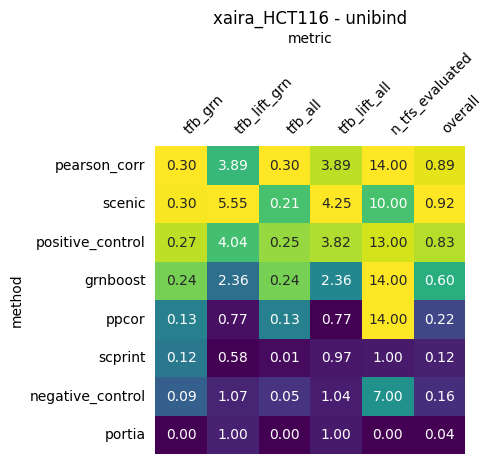

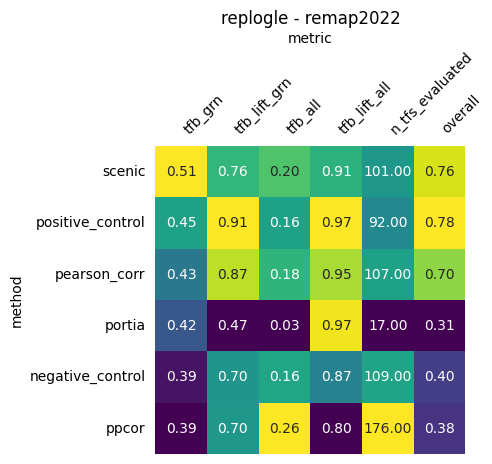

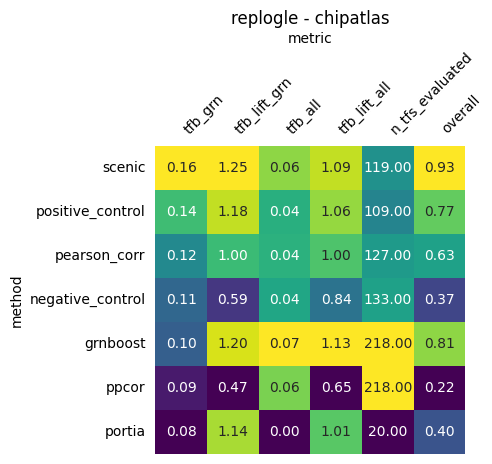

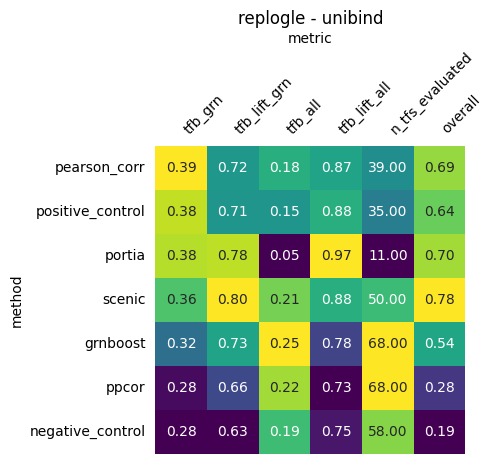

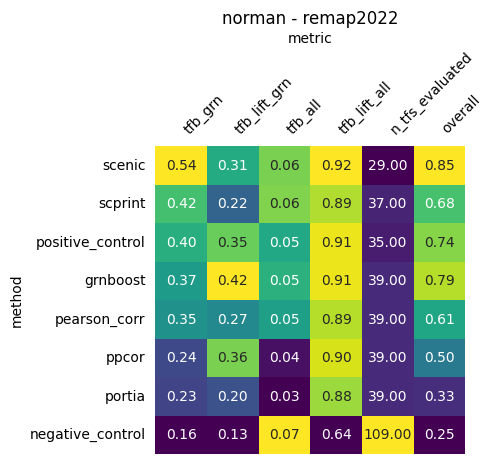

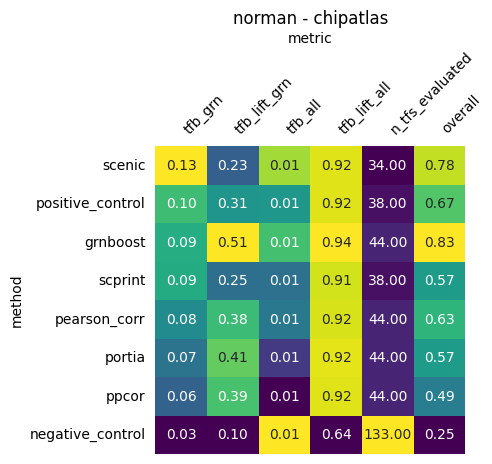

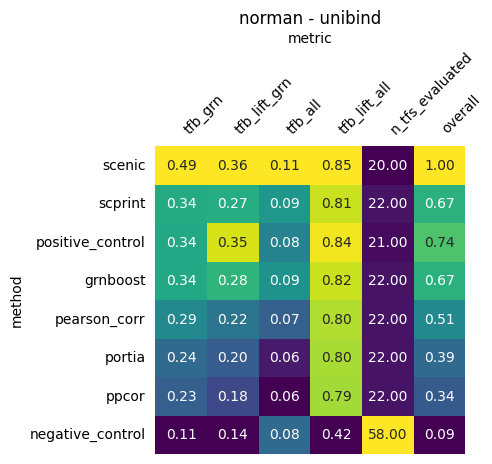

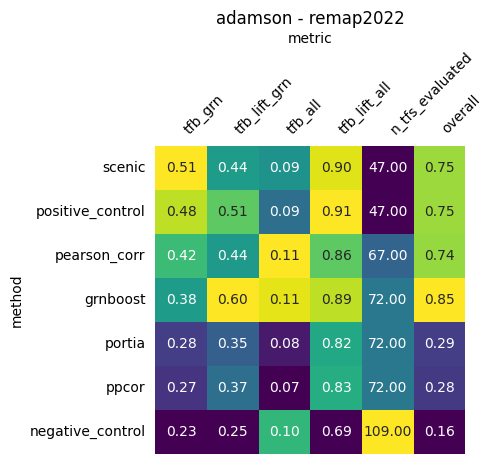

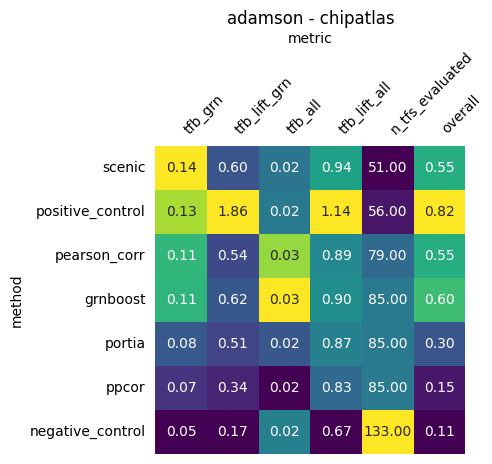

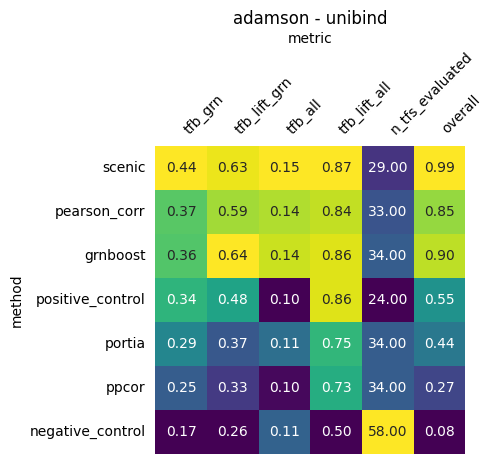

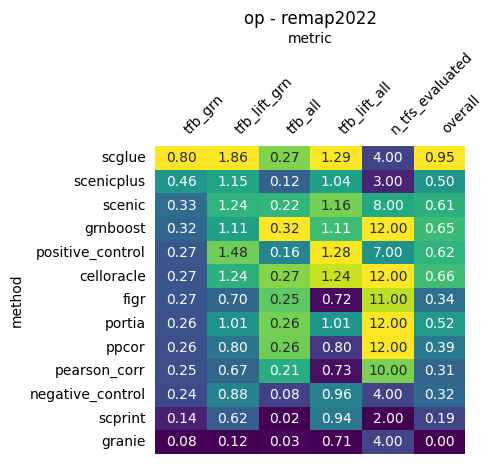

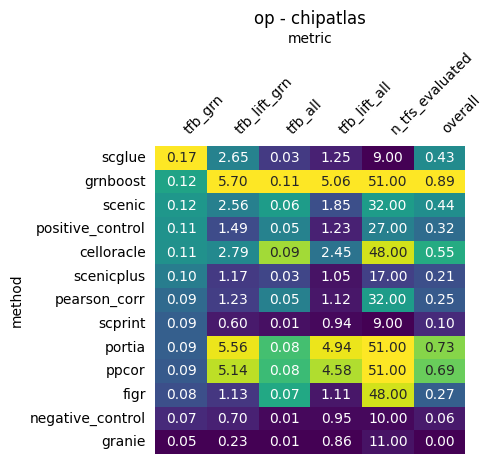

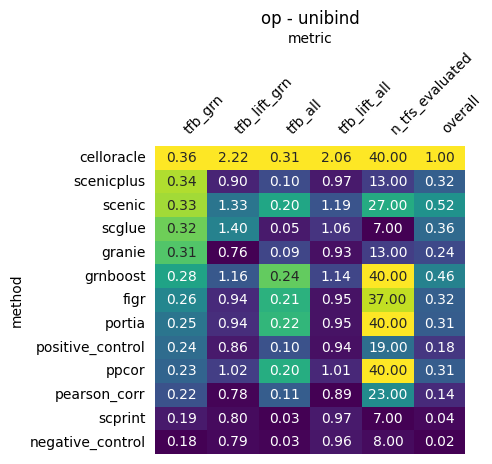

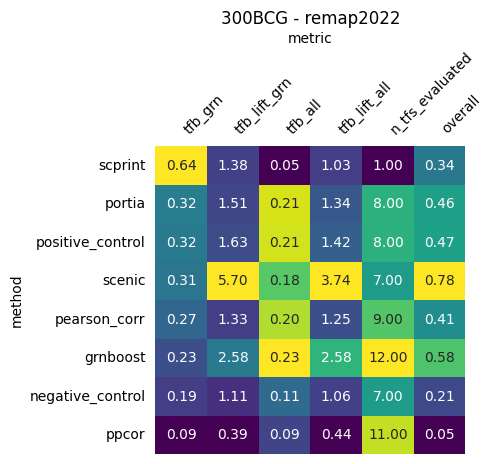

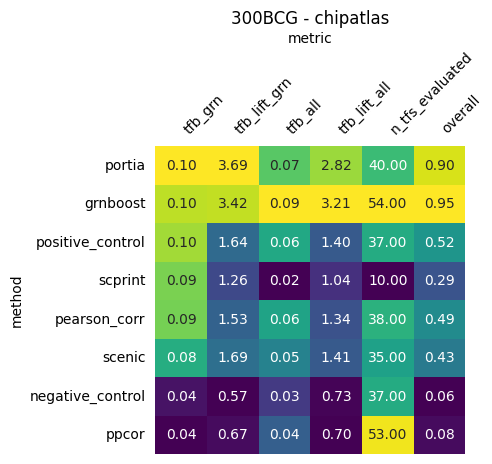

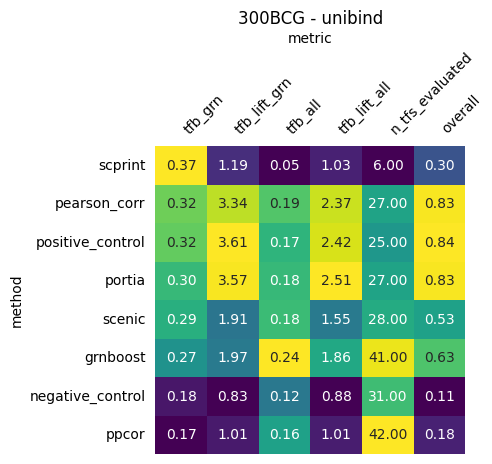

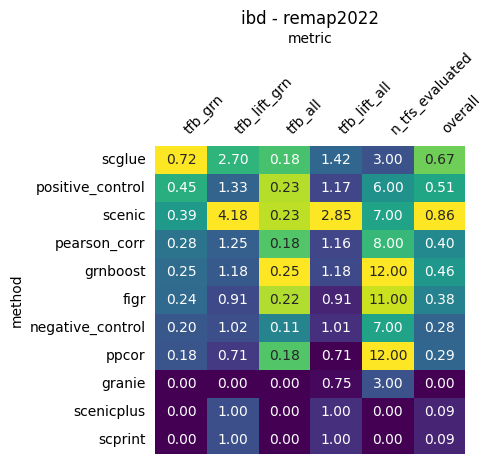

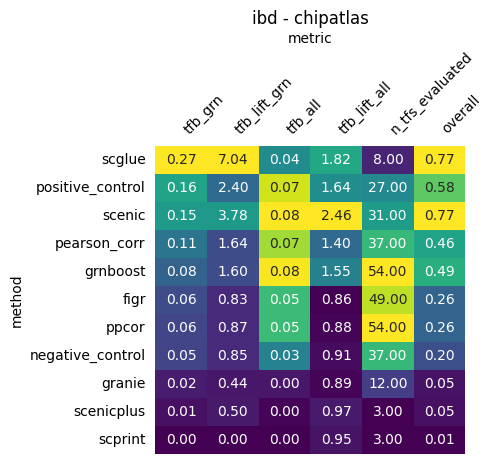

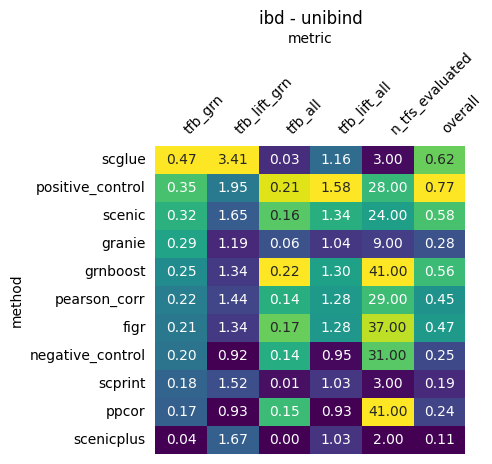

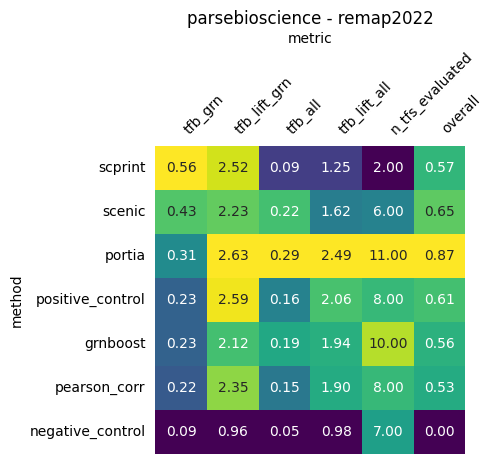

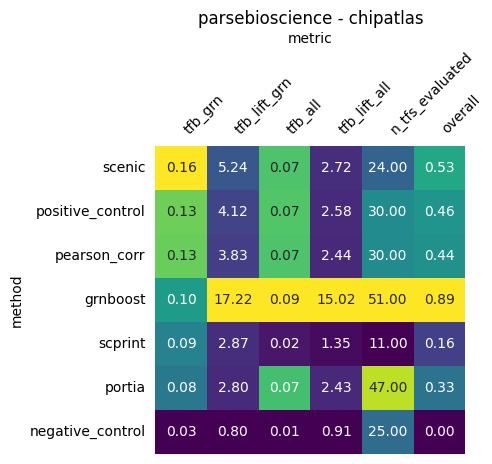

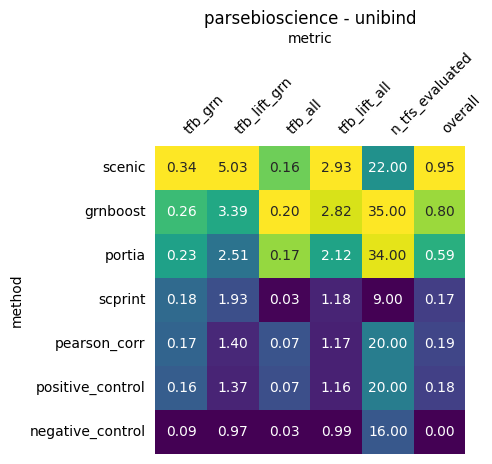

In [10]:
datasets = ['xaira_HEK293T', 'xaira_HCT116', 'replogle', 'norman',  'adamson', 'op',  "300BCG", "ibd", 'parsebioscience']
for dataset in datasets:
    for gt in ['remap2022', 'chipatlas', 'unibind']:
        try:
            df = pd.read_csv(f'output/tf_binding/summary_{dataset}_{gt}.csv')
        except FileNotFoundError:
            continue
        df = df.pivot(index='method', columns='metric', values='value')
        try:
            df = df[['tfb_grn', 'tfb_lift_grn', 
                      'tfb_all', 'tfb_lift_all',
                     'n_tfs_evaluated']]
        except KeyError as e:
            print(f"Missing columns in {dataset} - {gt}: {e}")
            continue
        metric_cols = [c for c in df.columns if c != 'n_tfs_evaluated']
        df_norm = df[metric_cols].copy()
        for c in metric_cols:
            min_val, max_val = df_norm[c].min(), df_norm[c].max()
            if max_val > min_val:
                df_norm[c] = (df_norm[c] - min_val) / (max_val - min_val)
            else:
                df_norm[c] = 0 
        df['overall'] = df_norm.mean(axis=1)
        df.sort_values('tfb_grn', ascending=False, inplace=True)
        plot_heatmap(df, name=f'{dataset}_{gt}', cmap="viridis")
        plt.title(f'{dataset} - {gt}')

FileNotFoundError: [Errno 2] No such file or directory: 'output/sem/sem_scores_ibd.csv'

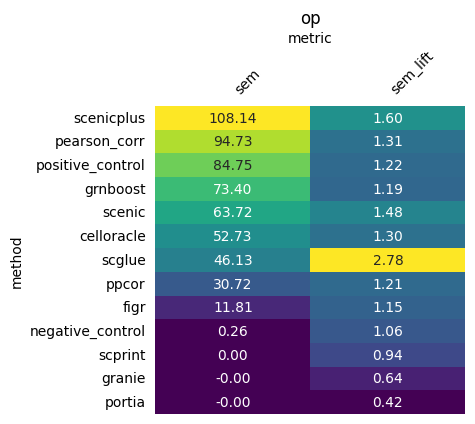

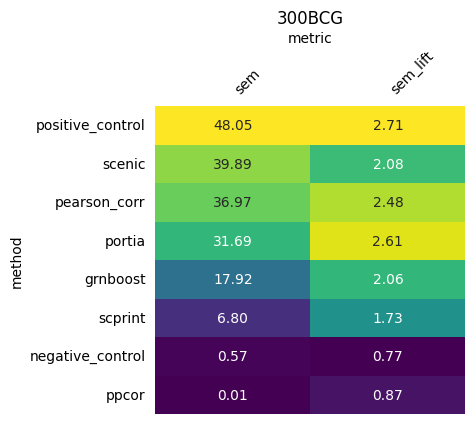

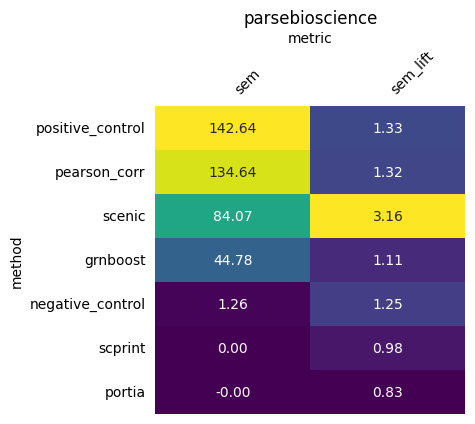

In [ ]:
for dataset in ['op', "300BCG", 'parsebioscience']:
    try:
        df = pd.read_csv(f'output/sem/sem_scores_{dataset}.csv')
    except:
        continue
    df = df.pivot(index='method', columns='metric', values='value')
    df.sort_values('sem', ascending=False, inplace=True)
    plot_heatmap(df, name='',  cmap="viridis")
    plt.title(f'{dataset}')
    # print('\n\n', dataset, '\n', df)

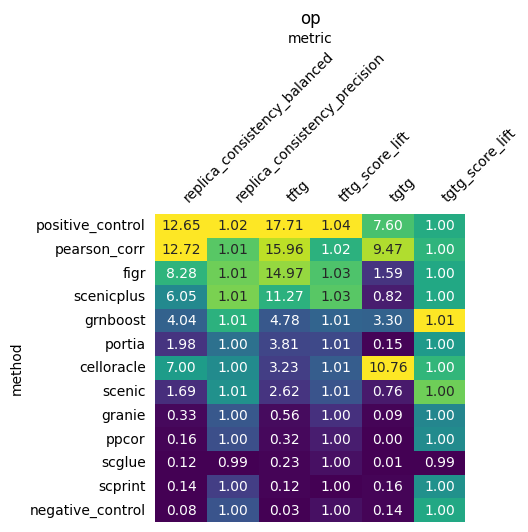

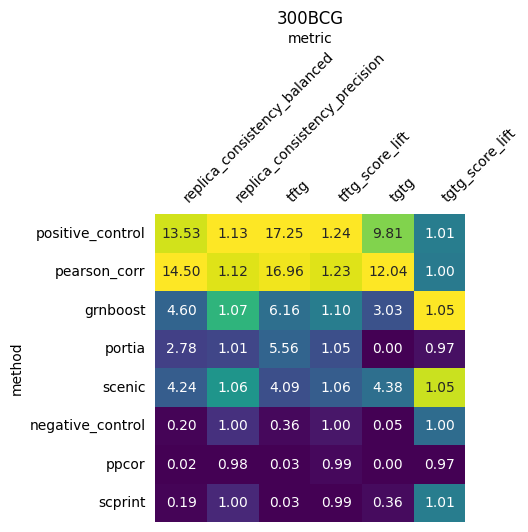

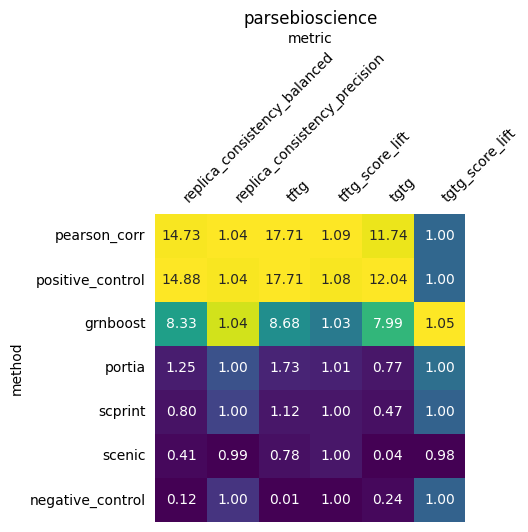

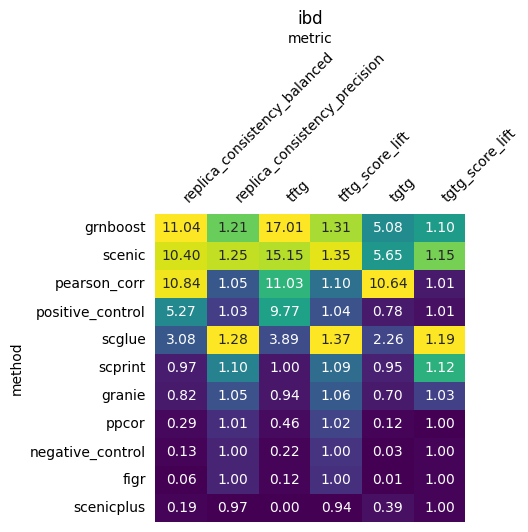

In [57]:
for dataset in ['op', "300BCG", 'parsebioscience', "ibd"]:
    df = pd.read_csv(f'output/replica_consistency/replica_consistency_scores_{dataset}.csv')
    df = df.pivot(index='method', columns='metric', values='value')
    df.sort_values('tftg', ascending=False, inplace=True)
    plot_heatmap(df, name='',  cmap="viridis")
    plt.title(f'{dataset}')
    # print('\n\n', dataset, '\n', df)

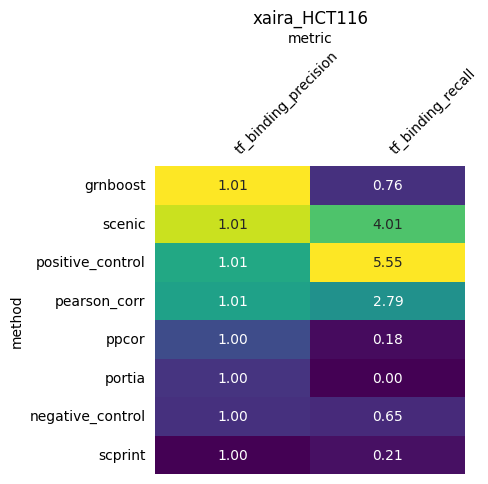

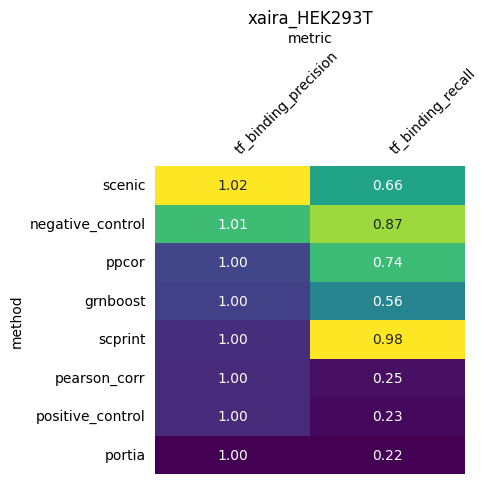

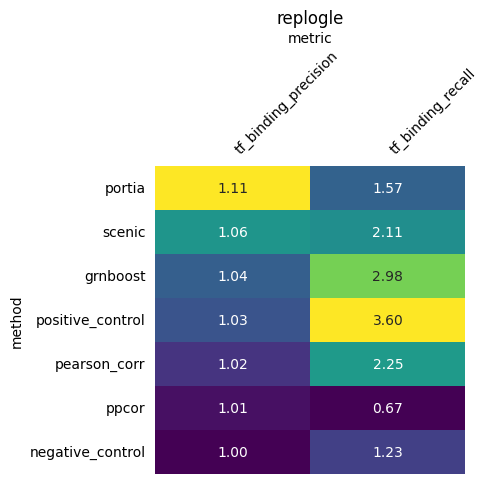

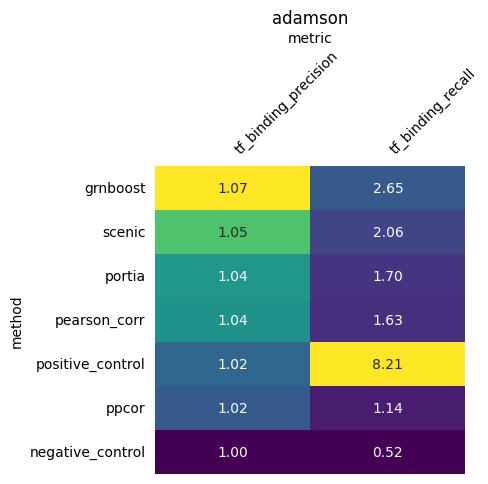

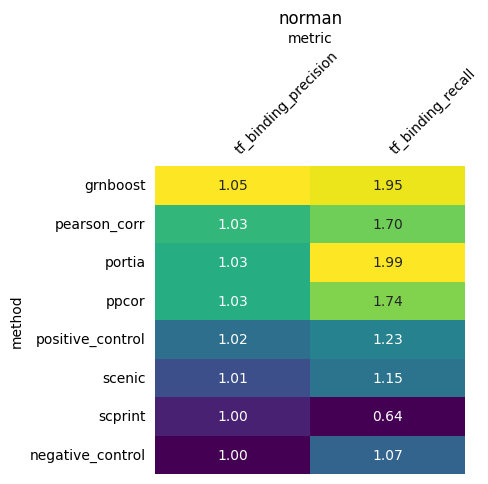

In [37]:
for dataset in [  'xaira_HCT116', 'xaira_HEK293T', 'replogle', 'adamson', 'norman']:
    df = pd.read_csv(f'output/tf_binding/tf_binding_scores_{dataset}.csv')
    # heatplot
    df = df.pivot(index='method', columns='metric', values='value')
    df.sort_values('tf_binding_precision', ascending=False, inplace=True)
    plot_heatmap(df, name='',  cmap="viridis")
    plt.title(f'{dataset}')

In [ ]:
!ls resources/datasets_raw/chipseq/chipatlas/Oth.Kid.50.AllAg.HEK293-T-REx.bed

fileList.tab		    Oth.Dig.50.AllAg.HCT_116.bed
Oth.Bld.50.AllAg.K-562.bed  Oth.Kid.50.AllAg.HEK293-T-REx.bed
Oth.Bld.50.AllAg.PBMC.bed


In [10]:
from src.metrics.tf_binding.acquire.script import read_peak_file
peaks_df = read_peak_file('resources/datasets_raw/chipseq/chipatlas/Oth.Kid.50.AllAg.HEK293-T-REx.bed', source='chip_atlas')

In [14]:
peaks_df['score'] = peaks_df['score'].astype(float)
peaks_df['score'].min(), peaks_df['score'].max(), peaks_df['score'].mean(), peaks_df['score'].median()

(500.0, 1000.0, 691.5878787878788, 657.0)

## Encode

In [ ]:
# !ls resources/datasets_raw/chipseq/encode/metadata.txt
df = pd.read_csv('resources/datasets_raw/chipseq/encode/metadata.txt', sep='\t')
df = df[['Experiment target', 'Biosample term name', 'Experiment accession']]

# Read results of metrics sem

In [13]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

rr_all = []

for dataset in ['300BCG', 'op', 'parsebioscience']:
    for method in (
        "negative_control", "pearson_corr", "positive_control", "ppcor", "portia",
        "scenic", "grnboost", "scprint", "scenicplus", "celloracle",
        "scglue", "figr", "granie"
    ):
        file_name = f'output/sem/sem_{dataset}_{method}.h5ad'
        if os.path.exists(file_name):
            adata = sc.read_h5ad(file_name)
            ids = adata.uns['metric_ids']
            values = np.array(adata.uns['metric_values'])  # ensure numpy
            
            rr_all.append({
                'method': method,
                'dataset': dataset,
                'value': values[0],
                'ids': ids[0]
            })

# Concatenate results
rr_all = pd.DataFrame(rr_all)

print(rr_all.head())
rr_all[rr_all['dataset']=='parsebioscience'].sort_values('value', ascending=False)

             method dataset      value  ids
0  negative_control  300BCG  -0.000112  sem
1      pearson_corr  300BCG   5.232835  sem
2  positive_control  300BCG  12.513887  sem
3             ppcor  300BCG  -0.000268  sem
4            portia  300BCG   1.106674  sem


,method,dataset,value,ids
23,positive_control,parsebioscience,[[57.06260223529691]],sem
22,pearson_corr,parsebioscience,55.718537,sem
26,grnboost,parsebioscience,32.865531,sem
25,scenic,parsebioscience,4.993123,sem
24,portia,parsebioscience,2.41019,sem
27,scprint,parsebioscience,0.713592,sem
21,negative_control,parsebioscience,-0.000242,sem


# Overlap of genes in inference and evaluation datasets

# UMAP of perturbations

In [ ]:
!ls resources/extended_data/

adamson_bulk.h5ad  nakatake_bulk.h5ad  replogle_train_sc.h5ad
HCT116_bulk.h5ad   norman_bulk.h5ad    xaira_HCT116_bulk.h5ad
HCT116_sc.h5ad	   op_bulk.h5ad        xaira_HCT116_sc.h5ad
HEK293T_bulk.h5ad  replogle_bulk.h5ad  xaira_HEK293T_bulk.h5ad
HEK293T_sc.h5ad    replogle_sc.h5ad    xaira_HEK293T_sc.h5ad


Processing dataset: xaira_HCT116


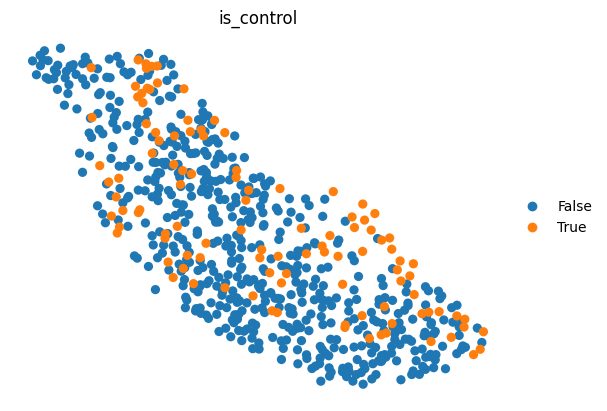

Processing dataset: xaira_HEK293T


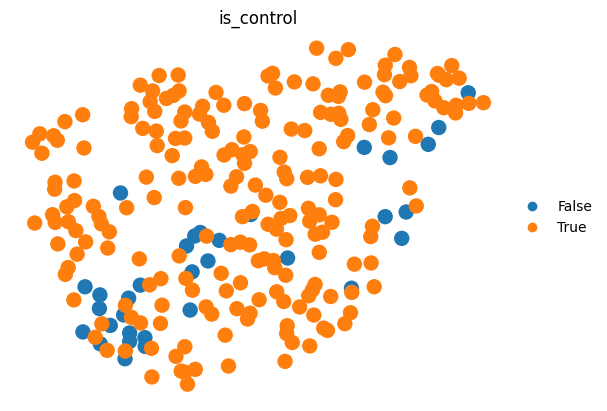

Processing dataset: replogle


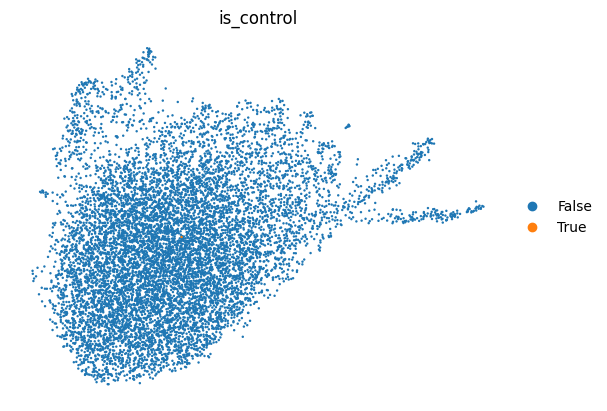

In [ ]:
for dataset in ['xaira_HCT116', 'xaira_HEK293T', 'replogle']:
    print(f'Processing dataset: {dataset}')
    adata = ad.read_h5ad(f'resources/extended_data/{dataset}_bulk.h5ad')

    adata.X = adata.layers['lognorm']
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    sc.pl.umap(adata,
        color=['is_control'],
        frameon=False,
        wspace=0.5)

# Assemble the results from differnet runs

In [ ]:
!rm -r resources/results/all_main/

In [ ]:
import os
import shutil
import yaml
from pathlib import Path
from collections import OrderedDict

base_dir = 'resources/results/'
save_dir = 'resources/results/all_main/'
runs = ['op', 'nakatake', 'norman', 'replogle', 'adamson']

os.makedirs(save_dir, exist_ok=True)

# 1. Copy one version of the identical files
identical_files = ['method_configs.yaml', 'metric_configs.yaml']
for fname in identical_files:
    src = os.path.join(base_dir, f'{runs[0]}_run', fname)
    dst = os.path.join(save_dir, fname)
    shutil.copyfile(src, dst)
    print(f"Copied identical file: {fname}")

# 2. Merge dataset_uns.yaml by appending all contents
merged_uns = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'dataset_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        merged_uns.extend(data)
        
with open(os.path.join(save_dir, 'dataset_uns.yaml'), 'w') as f:
    yaml.dump(merged_uns, f)
print("Merged: dataset_uns.yaml")

# 3. Merge score_uns.yaml similarly
merged_scores = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'score_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        # - remove those with missing (because of the metric)
        data = [d for d in data if d is not None and 'missing' not in str(d)]
        
        # print(str(data[0]))
        # aa
        # missing
        if data:
            if isinstance(data, dict):
                merged_scores.append(data)
            elif isinstance(data, list):
                merged_scores.extend(data)
            else:
                print(f"Unexpected format in {path}: {type(data)}")

with open(os.path.join(save_dir, 'score_uns.yaml'), 'w') as f:
    yaml.dump(merged_scores, f)
print("Merged: score_uns.yaml")

# 4. Merge trace.txt with deduplication
seen_lines = OrderedDict()
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'trace.txt')
    
    with open(path, 'r') as f:
        for line in f:
            seen_lines[line] = None

with open(os.path.join(save_dir, 'trace.txt'), 'w') as f:
    for line in seen_lines.keys():
        f.write(line)
df = pd.read_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
df = df.drop_duplicates(subset=['name'])
df.to_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
print("Merged: trace.txt (duplicates removed)")

# 5. Copy other unknown files/directories
all_known = set(identical_files + ['dataset_uns.yaml', 'score_uns.yaml', 'trace.txt'])

for run in runs:
    run_dir = Path(base_dir) / f'{run}_run'
    for file_path in run_dir.iterdir():
        if file_path.name in all_known:
            continue

        dest_path = Path(save_dir) / file_path.name

        if dest_path.exists():
            dest_path = Path(save_dir) / f"{file_path.stem}_{run}{file_path.suffix}"

        if file_path.is_file():
            shutil.copyfile(file_path, dest_path)
            print(f"Copied unique file: {file_path.name} → {dest_path.name}")
        elif file_path.is_dir():
            shutil.copytree(file_path, dest_path)
            print(f"Copied unique directory: {file_path.name} → {dest_path.name}")

Copied identical file: method_configs.yaml
Copied identical file: metric_configs.yaml
Merged: dataset_uns.yaml
Merged: score_uns.yaml
Merged: trace.txt (duplicates removed)
Copied unique file: state.yaml → state.yaml
Copied unique file: op_.celloracle.celloracle.prediction.h5ad → op_.celloracle.celloracle.prediction.h5ad
Copied unique file: scplus_mdata.h5mu.2DAaAA8E → scplus_mdata.h5mu.2DAaAA8E
Copied unique file: op_.negative_control.negative_control.prediction.h5ad → op_.negative_control.negative_control.prediction.h5ad
Copied unique file: op_.scenicplus.scenicplus.prediction.h5ad → op_.scenicplus.scenicplus.prediction.h5ad
Copied unique file: op_.portia.portia.prediction.h5ad → op_.portia.portia.prediction.h5ad
Copied unique file: op_.granie.granie.prediction.h5ad → op_.granie.granie.prediction.h5ad
Copied unique file: op_.scprint.scprint.prediction.h5ad → op_.scprint.scprint.prediction.h5ad
Copied unique file: op_.pearson_corr.pearson_corr.prediction.h5ad → op_.pearson_corr.pearso

# Rename grnboost2 to grnboost

In [ ]:
import os

target_dir = 'resources/results/all_main'

for root, _, files in os.walk(target_dir):
    for fname in files:
        fpath = os.path.join(root, fname)

        # Skip binary files (optional safety)
        try:
            with open(fpath, 'r', encoding='utf-8') as f:
                content = f.read()
        except UnicodeDecodeError:
            continue  # likely a binary file, skip it

        if 'grnboost2' in content:
            content = content.replace('grnboost2', 'grnboost')
            with open(fpath, 'w', encoding='utf-8') as f:
                f.write(content)
            print(f"Updated: {fpath}")

Updated: resources/results/all_main/trace.txt
Updated: resources/results/all_main/method_configs.yaml
Updated: resources/results/all_main/score_uns.yaml


## Create Nakatake test

In [ ]:
adata = ad.read_h5ad('resources/grn_benchmark/inference_data/nakatake_rna.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/inference_data/nakatake_rna.h5ad')

In [ ]:
adata = ad.read_h5ad('resources/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')